camera calibration with planar calibration target using the method described by Zhang

In [1]:
# load the images
import pathlib

image_dir = "calibration_images"

all_images = pathlib.Path(image_dir).glob('*.png')
all_images = [str(path) for path in all_images]

print(all_images)



['calibration_images/23.png', 'calibration_images/57.png', 'calibration_images/81.png', 'calibration_images/40.png', 'calibration_images/49.png', 'calibration_images/70.png', 'calibration_images/34.png', 'calibration_images/95.png', 'calibration_images/30.png', 'calibration_images/28.png', 'calibration_images/85.png', 'calibration_images/0.png', 'calibration_images/32.png', 'calibration_images/66.png', 'calibration_images/13.png', 'calibration_images/53.png', 'calibration_images/97.png', 'calibration_images/11.png', 'calibration_images/33.png', 'calibration_images/65.png', 'calibration_images/73.png', 'calibration_images/6.png', 'calibration_images/56.png', 'calibration_images/10.png', 'calibration_images/76.png', 'calibration_images/99.png', 'calibration_images/60.png', 'calibration_images/25.png', 'calibration_images/45.png', 'calibration_images/84.png', 'calibration_images/18.png', 'calibration_images/91.png', 'calibration_images/8.png', 'calibration_images/3.png', 'calibration_imag

In [18]:
# for all images, load the image and detect the marker corners using opencv

import cv2
import cv2.aruco
import numpy as np
np.set_printoptions(precision=2, suppress=True)


rejected_images = []

# see the pdf file in the airo-camera-toolkit/docs folder
aruco_dict =  cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
charuco_board = cv2.aruco.CharucoBoard((7, 5), 0.04, 0.031, aruco_dict)
corner_dict = {}

for image in all_images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

    n_corners, charuco_corners, ids = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, charuco_board)

    for i in range(len(ids) - 1):
        if ids[i] !=i:
            print(f"Error: {image} has unsorted ids")
    if n_corners > 0:
        # refine corners
        charuco_corners = cv2.cornerSubPix(gray, charuco_corners, winSize=(3, 3), zeroZone=(-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))

    if not len(charuco_corners) == 24:
        print(f"Error: {image} has {len(charuco_corners)} corners")
        rejected_images.append(image)
    else:
        corner_dict[image] = {"corners": corners, "charuco_corners": charuco_corners, "ids": ids}

print(f"Rejected images: {rejected_images}")
all_images = [image for image in all_images if image not in rejected_images]

# visualize the detected corners
import matplotlib.pyplot as plt

for image in all_images:
    img = cv2.imread(image)
    corners = corner_dict[image]
    img = cv2.aruco.drawDetectedCornersCharuco(img, np.array(corners["charuco_corners"]), np.array(corners["ids"]), (0, 255, 0))

    # convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    plt.show()

Rejected images: []


In [3]:
# create real-world planar coordinates. points are in a 4x6 grid with 40mm spacing 

# create the planar coordinates
planar_coords = []
for j in range(4):
    for i in range(6):
        planar_coords.append([i*0.04, j*0.04, 0])
print(planar_coords)



[[0.0, 0.0, 0], [0.04, 0.0, 0], [0.08, 0.0, 0], [0.12, 0.0, 0], [0.16, 0.0, 0], [0.2, 0.0, 0], [0.0, 0.04, 0], [0.04, 0.04, 0], [0.08, 0.04, 0], [0.12, 0.04, 0], [0.16, 0.04, 0], [0.2, 0.04, 0], [0.0, 0.08, 0], [0.04, 0.08, 0], [0.08, 0.08, 0], [0.12, 0.08, 0], [0.16, 0.08, 0], [0.2, 0.08, 0], [0.0, 0.12, 0], [0.04, 0.12, 0], [0.08, 0.12, 0], [0.12, 0.12, 0], [0.16, 0.12, 0], [0.2, 0.12, 0]]


In [89]:
# for each image, find the homography

homography_dict = {}

for image in all_images:
    corners = corner_dict[image]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # make the corners homogeneous
    img_corners  = np.array(corners["charuco_corners"])
    # drop second dimension
    img_corners = img_corners.reshape(-1,2)
    img_corners = np.hstack([img_corners, np.ones((img_corners.shape[0],1))])

    # make world coords XY homogeneous
    p = np.array(planar_coords)
    p[:,2] = 1
    

    # find the homography
    H,retval = cv2.findHomography(p, img_corners)
   # print(H)

    # check 
    # get reprojection error

    # project the planar coordinates to the image
    img_coords = np.dot(H, p.T)
    img_coords = img_coords/img_coords[2,:]
    img_coords = img_coords[:2,:].T
    img_coords = img_coords.reshape(-1,2)

    distances = np.linalg.norm(img_coords - img_corners[:,:2], axis=1)
    l2_error = np.average(distances)
    print(l2_error)

    homography_dict[image] = {"H": H, "l2_error": l2_error}



0.47702716246194116
0.4205628347668604
0.20571987371251457
0.1445343989704737
0.4647030922974196
0.1878718152242622
1.0791544042724677
0.5097198685888416
0.5096137654052494
0.8258221253921345
1.0479726488483205
0.4614186593997014
0.4258716217961877
0.41057689674051795
1.0469466520386426
1.500806877592155
0.31267065727390125
0.8933978264826058
0.3014673496278846
0.32407185186046067
1.2858456747954998
0.37093157077699157
0.32187115819466255
1.2606452892865578
0.1789898734537275
0.3257923303193769
0.33706995986231475
0.2601996383860444
0.5681442374535911
0.8683985025251449
0.7386123745111407
0.6469409842560453
0.14592659868779942
0.34401595787942413
0.17283081148928814
0.49754485084193495
0.3950755627357901
0.23455881717755153
0.25441910168840787
2.5226981289697368
0.42271111811661005
0.7619760123245441
0.14661625584017643
0.3663799161361047
0.4078318091123581
0.9970360726884415
1.3125970802694027
0.18190691836265424
0.8415295857417281
0.18065064209881945
0.8200848174872646
0.251920804207

In [90]:
# calibrate camera using zhang method algebraic solution


def v_ij(H,i,j):
    row = [H[i,0]*H[j,0], H[i,0]*H[j,1] + H[i,1]*H[j,0], H[i,1]*H[j,1], H[i,2]*H[j,0] + H[i,0]*H[j,2], H[i,2]*H[j,1] + H[i,1]*H[j,2], H[i,2]*H[j,2]]
    return np.array(row)


V = np.zeros((2*len(all_images), 6))
for i,img_path in enumerate(homography_dict.keys()):
    H = homography_dict[img_path]["H"]
    V[2*i] = v_ij(H,0,1)
    V[2*i+1] = v_ij(H,0,0) - v_ij(H,1,1)
U,S,Vt = np.linalg.svd(V)
b = Vt[-1]

B = np.array([[b[0], b[1], b[3]], [b[1], b[2], b[4]], [b[3], b[4], b[5]]])

v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2])/(B[0,0]*B[1,1] - B[0,1]*B[0,1])
l = B[2,2] - (B[0,2]*B[0,2] + v0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
alpha = np.sqrt(l/B[0,0])
beta = np.sqrt(l*B[0,0]/(B[0,0]*B[1,1] - B[0,1]*B[0,1]))
gamma = -B[0,1]*alpha*alpha*beta/l
u0 = gamma*v0/alpha - B[0,2]*alpha*alpha/l


K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
print(K)
                        

[[ 2.417 -0.183  4.31 ]
 [ 0.     2.855 -0.088]
 [ 0.     0.     1.   ]]


In [73]:
# use opencv to calibrate
from random import sample
objPoints = []
imgPoints = []

calib_images = sample(all_images, 90)
for img in calib_images:
    corners = corner_dict[img]
    objPoints.append(np.array(planar_coords))
    imgPoints.append(corners["charuco_corners"])

objPoints = np.array(objPoints)
print(objPoints.shape)
imgPoints = np.array(imgPoints)
imgPoints = imgPoints.reshape(imgPoints.shape[0],imgPoints.shape[1],2)
print(imgPoints.shape)
imgPoints = imgPoints.astype(np.float32)
objPoints = objPoints.astype(np.float32)

# no distortion optimization!
retval, cameraMatrix, distCoeffs, rvecs, tvecs, std_dev_intrinsics,std_dev_extrinsics,per_view_rms = cv2.calibrateCameraExtended(objPoints, imgPoints, gray.shape[::-1], None, np.zeros(5)) #, flags=cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_TANGENT_DIST)

np.set_printoptions(precision=3)
print(cameraMatrix)

print(distCoeffs)




(90, 24, 3)
(90, 24, 2)
[[1364.614    0.     958.7  ]
 [   0.    1365.874  561.048]
 [   0.       0.       1.   ]]
[ 0.194 -0.641 -0.001 -0.001  0.59 ]


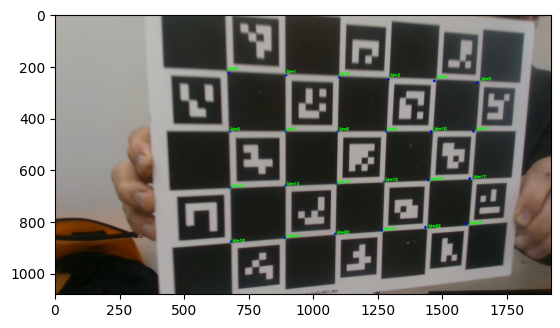

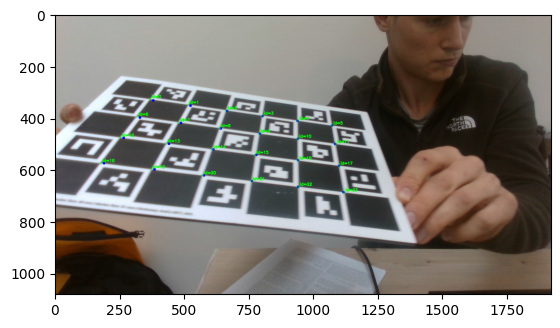

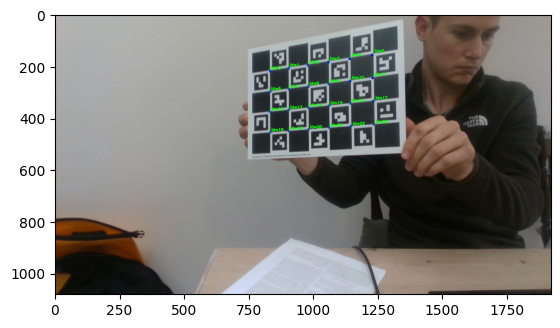

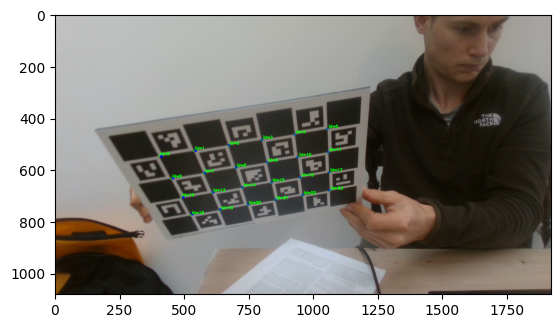

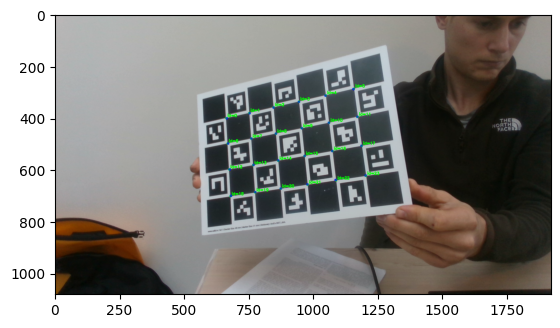

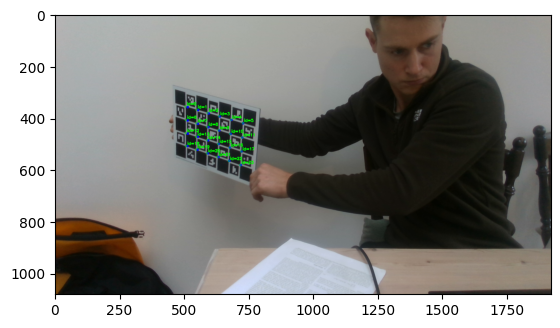

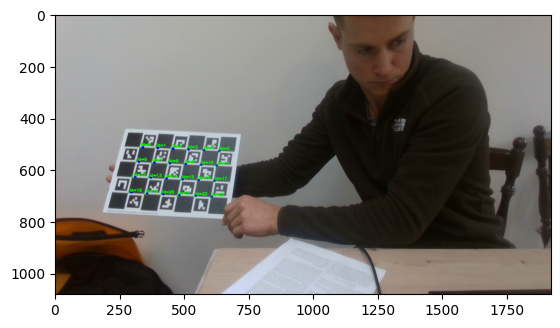

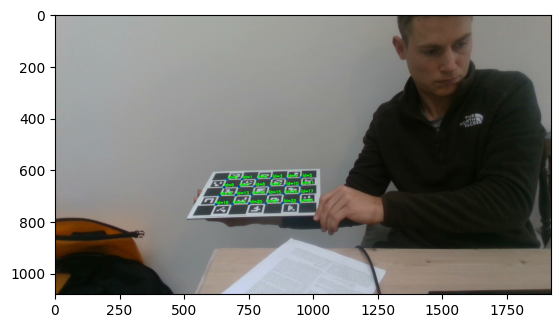

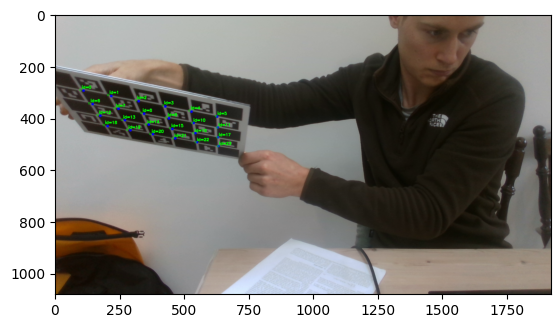

Reprojection error: 4.046256083925652 pixels


In [84]:
# for each image, reproject the planar coordinates to the image using the estimated camera matrix and extrinsics.
reprojection_errors = []
for i, img_path in enumerate(calib_images):
    world_coords = np.array(planar_coords)
    rvec = rvecs[i]
    tvec = tvecs[i]

    # create homogeneous matrix from tvec and rvec 
    R,_ = cv2.Rodrigues(rvec)
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = tvec.flatten()

    # project the planar coordinates to the image
    world_coords = np.hstack([world_coords, np.ones((world_coords.shape[0],1))]).T
    img_coords = cameraMatrix@ (T @ world_coords)[:3,:]
    img_coords = img_coords/img_coords[2,:]
    img_coords = img_coords[:2,:].T


    reprojection_error = img_coords - imgPoints[i]
    reprojection_errors.extend(reprojection_error)


    # show image coords on the image
    img = cv2.imread(img_path)
    for j in range(len(img_coords)):
        cv2.circle(img, (int(img_coords[j,0]), int(img_coords[j,1])), 5, (255,0,0), -1)
    img = cv2.aruco.drawDetectedCornersCharuco(img, np.array(corner_dict[img_path]["charuco_corners"]), np.array(corner_dict[img_path]["ids"]), (0, 255, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if i % 10 == 0:
        plt.imshow(img)
        plt.show()
        pass


reprojection_distances = np.linalg.norm(reprojection_errors, axis=1)
reprojection_error = np.mean(reprojection_distances)
print(f"Reprojection error: {reprojection_error} pixels")
    


In [81]:
import pyrealsense2 as rs

# shut camera down if it is running
ctx = rs.context()
devices = ctx.query_devices()
for dev in devices:
    dev.hardware_reset()

config = rs.config()

config.enable_stream(rs.stream.color, 1920,1080, rs.format.rgb8, 15)

# Avoid having to reconnect the USB cable, see https://github.com/IntelRealSense/librealsense/issues/6628#issuecomment-646558144
ctx = rs.context()
devices = ctx.query_devices()
for dev in devices:
    dev.hardware_reset()

pipeline = rs.pipeline()

pipeline.start(config)
# Get intrinsics matrix
profile = pipeline.get_active_profile()
color_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))
intrinsics = color_profile.get_intrinsics()
intrinsics_matrix = np.array(
    [
        [intrinsics.fx, 0, intrinsics.ppx],
        [0, intrinsics.fy, intrinsics.ppy],
        [0, 0, 1],
    ]
)

print(intrinsics_matrix)

[[1372.015    0.     967.68 ]
 [   0.    1369.215  558.417]
 [   0.       0.       1.   ]]
